In [1]:
import pyforest
import random
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.image as mpim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import keras_tuner as kt

In [2]:
# Access the directory
data_dir = 'C:/MadhuPES/SEMESTER6/PRASUNET/Prasunet_ML_05/Dataset/dataset/food-101/food-101/images'
class_names_file_path = 'C:/MadhuPES/SEMESTER6/PRASUNET/Prasunet_ML_05/Dataset/dataset/food-101/food-101/meta/classes.txt'

# Read class names from the file into a list
with open(class_names_file_path, 'r') as file:
    all_class_names = [line.strip() for line in file]

# Choose 10 classes randomly
chosen_classes = random.sample(all_class_names, 10)
print(chosen_classes)

# List of real class names
classes = chosen_classes

# Set the number of classes
num_classes = len(classes)

['cup_cakes', 'chicken_quesadilla', 'escargots', 'grilled_salmon', 'pizza', 'hamburger', 'seaweed_salad', 'lobster_roll_sandwich', 'huevos_rancheros', 'chicken_wings']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

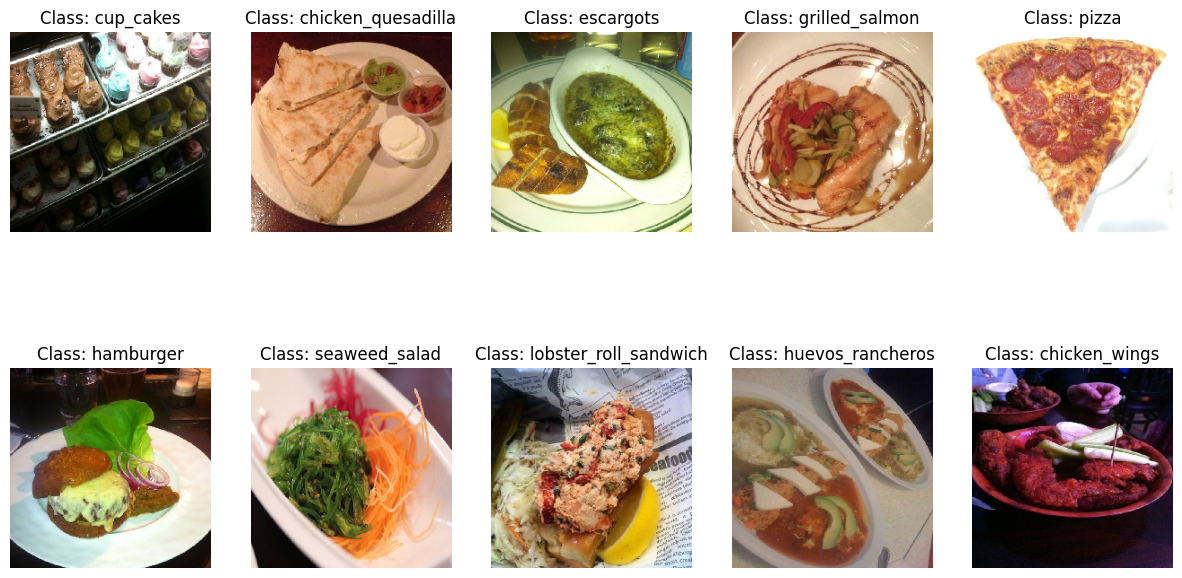

In [3]:
# Display a random image from each class folder
plt.figure(figsize=(15, 8))
for i in range(num_classes):
    class_folder = classes[i]
    class_path = os.path.join(data_dir, class_folder)
    
    # Get a random image from the class folder
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    
    # Load and display the image
    img = load_img(image_path, target_size=(224, 224))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_folder}")
    plt.axis('off')

plt.show()

In [4]:
#Create a sequential model
model = models.Sequential()

# Add convolutional layers with activation and pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split the data into training and validation
)

batch_size = 32

# Use the same generator for both training and validation
generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # For training data
    classes=classes
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # For validation data
    classes=classes
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/50
250/250 [==============================] - 532s 2s/step - loss: 2.1183 - accuracy: 0.2261 - val_loss: 1.9660 - val_accuracy: 0.3010
Epoch 2/50
250/250 [==============================] - 466s 2s/step - loss: 1.9521 - accuracy: 0.3014 - val_loss: 1.8462 - val_accuracy: 0.3570
Epoch 3/50
250/250 [==============================] - 464s 2s/step - loss: 1.8652 - accuracy: 0.3416 - val_loss: 1.7531 - val_accuracy: 0.3665
Epoch 4/50
250/250 [==============================] - 464s 2s/step - loss: 1.8071 - accuracy: 0.3666 - val_loss: 1.7593 - val_accuracy: 0.3860
Epoch 5/50
250/250 [==============================] - 465s 2s/step - loss: 1.7592 - accuracy: 0.3841 - val_loss: 1.6722 - val_accuracy: 0.4175
Epoch 6/50
250/250 [==============================] - 472s 2s/step - loss: 1.7304 - accuracy: 0.4020 - val_loss: 1.6458 - val_accuracy: 0.4230
Epoch 7/50
250/250 [==============================] - 47

In [8]:
# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

63/63 [==============================] - 37s 585ms/step - loss: 1.3519 - accuracy: 0.5490
Loss: 1.351875901222229
Accuracy: 0.5490000247955322


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

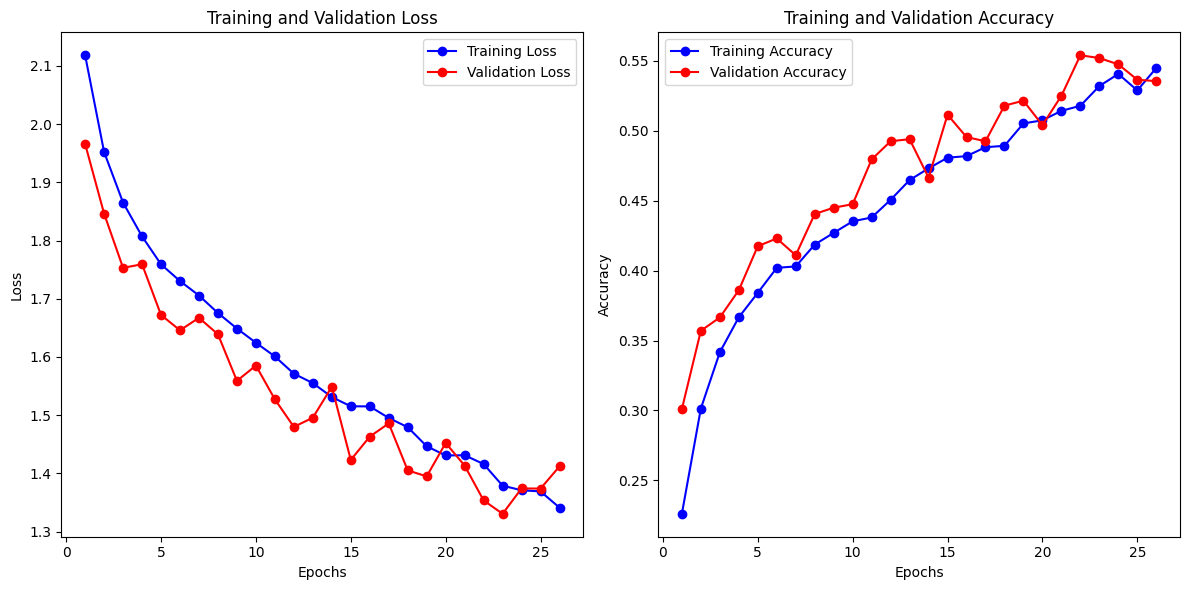

In [7]:
# Visualize the training history (loss and accuracy over epochs)
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()